In [22]:
import numpy as np
from icecream import ic
from tqdm import tqdm
import cProfile 
import time
import warnings
import math


In [23]:
#warning settings
np.seterr(all="ignore") #ignore np warnings, the output will be nan or inf and will be handled correctly in the code. (using np.errstate slows down the code)
# warnings.filterwarnings("ignore", category=RuntimeWarning)


{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

### Load a problem

In [24]:
TRAIN_TEST_RATIO = 0.8
PROBLEM_NUMBER = 5

# Load the problem data
problem = np.load(f'data/problem_{PROBLEM_NUMBER}.npz')
x_1 = problem['x']
y_1 = problem['y']

# Shuffle the data
permutation = np.random.permutation(len(y_1))
x_1 = x_1[:, permutation]
y_1 = y_1[permutation]

# Split the data into training and testing sets
problem_len = len(y_1)
train_size = int(TRAIN_TEST_RATIO * problem_len)

x_train = x_1[:, :train_size]
y_train = y_1[:train_size]
x_test = x_1[:, train_size:]
y_test = y_1[train_size:]

# Normalize the training and testing data
def normalize_data(x, y, feature_range=(0, 1)):
    """
    Normalize input (x) and output (y) data using min-max normalization.

    Parameters:
        x: np.ndarray, input data (variables, samples).
        y: np.ndarray, output data (samples).
        feature_range: tuple (min, max), range for normalization.

    Returns:
        x_norm: Min-max normalized input data.
        y_norm: Min-max normalized output data.
        x_stats: Dict containing min and max for x.
        y_stats: Dict containing min and max for y.
    """
    x_min = np.min(x, axis=1, keepdims=True)
    x_max = np.max(x, axis=1, keepdims=True)
    x_norm = (x - x_min) / (x_max - x_min) * (feature_range[1] - feature_range[0]) + feature_range[0]

    y_min = np.min(y)
    y_max = np.max(y)
    y_norm = (y - y_min) / (y_max - y_min) * (feature_range[1] - feature_range[0]) + feature_range[0]

    x_stats = {"min": x_min, "max": x_max}
    y_stats = {"min": y_min, "max": y_max}

    return x_norm, y_norm, x_stats, y_stats


# Normalize training and testing data
x_train_norm, y_train_norm, x_stats, y_stats = normalize_data(x_train, y_train)
x_test_norm, y_test_norm, _, _ = normalize_data(x_test, y_test)

# Print problem information
print(f"Problem number: {PROBLEM_NUMBER}, variables: {x_1.shape[0]}, "
      f"train size: {train_size}, test size: {problem_len - train_size}")
print(f"Training data: x shape: {x_train_norm.shape}, y shape: {y_train_norm.shape}")
print(f"Testing data: x shape: {x_test_norm}, y shape: {y_test_norm}")



Problem number: 5, variables: 2, train size: 4000, test size: 1000
Training data: x shape: (2, 4000), y shape: (4000,)
Testing data: x shape: [[0.92078199 0.74695889 0.02260014 ... 0.75231893 0.56828024 0.54576944]
 [0.72441757 0.22615249 0.87224514 ... 0.00507474 0.2607958  0.22734645]], y shape: [0.91273972 0.99844662 0.99999997 0.97785569 0.997182   0.9915937
 0.998729   0.99725255 0.9965031  0.92911827 0.99999891 0.99163247
 0.91341733 0.9990567  0.97120177 0.97910748 0.98124214 0.91665537
 0.99958068 0.99122565 0.99512286 0.99825274 0.99257457 0.9931591
 0.999231   0.99956896 0.99969536 0.99629727 0.99602015 0.99943074
 0.99629733 0.99999673 0.99998377 0.9997388  0.99869767 0.99994821
 0.99953238 0.91601988 0.99953611 0.9994408  0.9984369  0.99905649
 0.99639834 0.99348756 0.99931152 0.99937235 0.99999908 0.99734296
 0.99968686 0.99929912 0.99999905 0.99723192 0.99989156 0.99458644
 0.99683707 0.99921836 0.99846983 0.99865951 0.99921061 0.99999912
 0.9988797  0.98169423 0.62263895

### Numpy functions definition

In [16]:
unary_ops = [
    np.negative,
    np.abs,
    np.sqrt,
    np.exp,
    np.log,
    np.sin,
    np.cos,
    np.tan,
    # np.arcsin,
    # np.arccos,
    # np.arctan,
    # np.ceil,
    # np.floor
]

binary_ops = [
    np.add,
    np.subtract,
    np.multiply,
    np.divide,
    np.power,
    # np.maximum,
    # np.minimum,
    # np.mod
]


### Symbolic regression class

In [25]:
from tree import Tree

class SymbolicRegression:
    def __init__(self, population_size, max_generations, mutation_rate, elitism_size, grow_full_ratio):
        self.population_size = population_size
        self.max_generations = max_generations
        self.mutation_rate = mutation_rate
        self.best_fitness_history = []
        self.unary_ops = unary_ops
        self.binary_ops = binary_ops
        self.elitism_size = elitism_size
        self.grow_full_ratio = grow_full_ratio
        

        self.population =np.array([Tree("grow") for _ in range(int(population_size * self.grow_full_ratio))] + [Tree("full") for _ in range(int(population_size * (1 - self.grow_full_ratio)))])

    # Parents selection
    def select_parents(self):
        if np.random.rand() < 0:
            return self.select_parents_tournament()
        else:
            return self.rank_based_selection()

    def select_parents_tournament(self):
        tournament_size = 7
        tournament = list(np.random.choice(self.population, tournament_size))
        tournament.sort(key=lambda x: x.fitness)
        return tournament[0], tournament[1]

    # def fitness_proportional_selection(self, n_elems=2): #TODO:   implement this
    def rank_based_selection(self, n_elems=2):
        """
        Rank-based selection method.
        Assigns probabilities based on inversed ranks instead of absolute fitness values.
        """
        fitnesses = np.array([tree.fitness for tree in self.population])
        ranks = np.argsort(fitnesses)
        inversed_ranks = len(fitnesses) - ranks
        probabilities = inversed_ranks / np.sum(inversed_ranks)
        return np.random.choice(self.population, n_elems, p=probabilities)

    def select_parents_roulette(self):
        fitnesses = [tree.fitness for tree in self.population]
        total_fitness = sum(fitnesses)
        probabilities = [f / total_fitness for f in fitnesses]
        parent1, parent2 = np.random.choice(self.population, size=2, p=probabilities)
        return parent1, parent2

    def mutate(self, tree):
        if np.random.rand() < self.mutation_rate:
            if np.random.rand() < 0.5:
                tree.mutate_subtree()
            else:
                tree.mutate_single_node()

    def offspring_generation(self):
        new_population = np.array([])

        # Elitism   
        elite_individuals = self.population[:self.elitism_size]
        new_population = elite_individuals

        
        #Main loop
        while len(new_population) < self.population_size//2:
            parent1, parent2 = self.select_parents()
            offsprings=np.array([])
            if(np.random.rand() < 0.1):
                parent_clone=parent1.copy_tree()
                self.mutate(parent_clone)
                Tree.collapse_branch(parent_clone.root)
                parent_clone.compute_fitness()
                # if(parent_clone not in new_population):
                offsprings = np.append(offsprings, [parent_clone])

            else:    
                offspring1,offspring2=Tree.crossover(parent1, parent2)
                if(offspring1 is not None or offspring2 is not None):
                    Tree.collapse_branch(offspring1.root)
                    Tree.collapse_branch(offspring2.root)
                
                    # self.mutate(offspring1)
                    # self.mutate(offspring2)

                    #Trying stuff
                    # offspring1.compute_fitness()
                    # offspring2.compute_fitness()
                    # tmp_fitnesses=[tree.fitness for tree in new_population]
                    # if offspring1.fitness not in tmp_fitnesses:
                    #     offsprings.append(offspring1)
                    # if offspring2.fitness not in tmp_fitnesses:
                    #     offsprings.append(offspring2)
                    
                    offspring1.compute_fitness()
                    offspring2.compute_fitness()
                    #if osspring1 is not alredy in population, already defined the eq as the fitness comparison
                    # if offspring1 not in new_population:
                    #     offsprings = np.append(offsprings, [offspring1])
                    # if offspring2 not in new_population:
                    #     offsprings = np.append(offsprings, [offspring2])

               
                    

                    offsprings = np.append(offsprings, [offspring1, offspring2])

            new_population=np.concatenate((new_population,offsprings))
                
        return new_population


    def evolve(self):
        best_tree = None
        best_fitness = np.inf
        take_over = False
        # self.population.sort(key=lambda x: x.fitness) 
        #numpy sort of population over fitness
        self.population.sort()
        # print(f"Initial best fitness: {self.population[0].fitness}")
        # print(f"Initial best fitness: {self.population[1].fitness}")
        # print(f"Initial best fitness: {self.population[2].fitness}")
        # print(f"Initial worst fitness: {self.population[-1].fitness}")



        for generation in tqdm(range(self.max_generations)):
            
            if take_over:
                #trasform the population in set and then back to list to remove duplicates
                self.population=np.unique(self.population)
                #sort the population based on fitness
                self.population.sort()
                self.population = self.population[:int(self.population_size*0.1)]
                new_trees = np.array([Tree("grow") for _ in range(int(self.population_size*0.3))]+[Tree("grow") for _ in range(int(self.population_size*0.3))])
                self.population=np.concatenate((self.population,new_trees))
            
            
            new_population=self.offspring_generation()

            # for tree in new_population:
            #     tree.compute_fitness()
                
            self.population=np.concatenate((self.population,new_population))
            
            generation_fitnesses = [tree.fitness for tree in self.population]
            generation_best_fitness = min(generation_fitnesses)

            if generation_best_fitness < best_fitness:
                best_fitness = generation_best_fitness
                best_tree = self.population[np.argmin(generation_fitnesses)]
                self.best_fitness_history.append(best_fitness)
            #trim the population to the best population_size
            self.population.sort()
            self.population = self.population[:self.population_size]
            # print(f"Generation {generation + 1}, Best Fitness: {best_fitness}")
            

            n_best = [elem for elem in self.population if elem.fitness == self.population[0].fitness]
            take_over = False
            if len(n_best) > 0.9 * self.population_size:
                    take_over = True
                    # print(f"Takeover at {generation} gen")     
            if(generation%1000==0):
                print(f"Generation {generation + 1}, Best Fitness: {best_fitness}, Best Formula: {best_tree.to_np_formula()}")
            if best_fitness <= 1e-33:
                break   
        return best_tree, best_fitness






In [28]:
#Problem definition
POPULATION_SIZE = 200
MAX_GENERATIONS = 20000
MUTATION_RATE = 0.5
ELITISM_SIZE = 1
GROW_FULL_RATIO = 1
TREE_DEPTH = min(math.ceil(math.log(x_train.shape[0] + 1, 2)) + 2, 10)  # FIXME: temporary solution,IDK if it's good. (it's the depth to contain all the variables+1)
print("Tree depth:",TREE_DEPTH)
#TREE_DEPTH = 4
VAR_NUM = x_train.shape[0]
CONST_RANGE=10 # Constats will be in the range [-CONST_RANGE, CONST_RANGE]


Tree.set_params(unary_ops, binary_ops, VAR_NUM, 10,TREE_DEPTH, x_train_norm, y_train_norm, x_test_norm, y_test_norm)
regressor = SymbolicRegression(
    POPULATION_SIZE,
    MAX_GENERATIONS,
    MUTATION_RATE,
    ELITISM_SIZE,
    GROW_FULL_RATIO
    #(x_train, y_train)   # per lexicase
)




Tree depth: 4


  0%|          | 9/20000 [00:00<08:02, 41.41it/s]

Generation 1, Best Fitness: 0.0034786419034353454, Best Formula: np.sin(np.absolute(np.add(np.multiply(x[1], x[0]), np.multiply(-9.256026198394167, -4.892489611881015))))


  5%|▌         | 1002/20000 [01:02<21:50, 14.50it/s]

Generation 1001, Best Fitness: 0.0011859857687969994, Best Formula: np.cos(np.divide(np.power(x[1], np.power(x[0], -8.15308418106326)), np.cos(np.subtract(x[1], 6.816490956472819))))


 10%|█         | 2001/20000 [02:11<18:37, 16.10it/s]

Generation 2001, Best Fitness: 3.703661502237642e-05, Best Formula: np.cos(np.divide(np.power(x[1], np.add(2.561607597559224, x[1])), np.add(np.divide(2.6644242883512153, x[0]), np.subtract(x[0], 3.033970891312194))))


 15%|█▌        | 3004/20000 [03:14<16:09, 17.53it/s]

Generation 3001, Best Fitness: 3.2943508932073316e-05, Best Formula: np.cos(np.divide(np.power(x[1], np.add(2.7629001619937217, x[1])), np.add(np.divide(2.6459356216839485, x[0]), np.subtract(x[0], 3.033970891312194))))


 20%|██        | 4008/20000 [04:09<06:51, 38.82it/s]

Generation 4001, Best Fitness: 3.187693042644089e-05, Best Formula: np.cos(np.divide(np.power(x[1], np.add(2.7548571162504683, x[1])), np.add(np.divide(2.7629001619937217, x[0]), np.subtract(x[0], 3.1554982513859002))))


 25%|██▌       | 5004/20000 [04:59<12:51, 19.44it/s]

Generation 5001, Best Fitness: 3.120333886719059e-05, Best Formula: np.cos(np.divide(np.power(x[1], np.add(2.701691499694121, x[1])), np.add(np.divide(2.7629001619937217, x[0]), np.subtract(x[0], 3.155082651110847))))


 30%|███       | 6004/20000 [05:52<12:49, 18.19it/s]

Generation 6001, Best Fitness: 3.120333886719059e-05, Best Formula: np.cos(np.divide(np.power(x[1], np.add(2.701691499694121, x[1])), np.add(np.divide(2.7629001619937217, x[0]), np.subtract(x[0], 3.155082651110847))))


 35%|███▌      | 7006/20000 [06:44<09:43, 22.26it/s]

Generation 7001, Best Fitness: 3.120333886719059e-05, Best Formula: np.cos(np.divide(np.power(x[1], np.add(2.701691499694121, x[1])), np.add(np.divide(2.7629001619937217, x[0]), np.subtract(x[0], 3.155082651110847))))


 40%|████      | 8004/20000 [07:28<05:36, 35.65it/s]

Generation 8001, Best Fitness: 3.120333886719059e-05, Best Formula: np.cos(np.divide(np.power(x[1], np.add(2.701691499694121, x[1])), np.add(np.divide(2.7629001619937217, x[0]), np.subtract(x[0], 3.155082651110847))))


 45%|████▌     | 9008/20000 [08:01<05:32, 33.10it/s]

Generation 9001, Best Fitness: 3.120333886719059e-05, Best Formula: np.cos(np.divide(np.power(x[1], np.add(2.701691499694121, x[1])), np.add(np.divide(2.7629001619937217, x[0]), np.subtract(x[0], 3.155082651110847))))


 50%|█████     | 10008/20000 [08:34<04:46, 34.93it/s]

Generation 10001, Best Fitness: 3.120333886719059e-05, Best Formula: np.cos(np.divide(np.power(x[1], np.add(2.701691499694121, x[1])), np.add(np.divide(2.7629001619937217, x[0]), np.subtract(x[0], 3.155082651110847))))


 55%|█████▌    | 11000/20000 [09:28<09:27, 15.86it/s]

Generation 11001, Best Fitness: 3.120333886719059e-05, Best Formula: np.cos(np.divide(np.power(x[1], np.add(2.701691499694121, x[1])), np.add(np.divide(2.7629001619937217, x[0]), np.subtract(x[0], 3.155082651110847))))


 60%|██████    | 12003/20000 [10:27<08:11, 16.28it/s]

Generation 12001, Best Fitness: 3.120333886719059e-05, Best Formula: np.cos(np.divide(np.power(x[1], np.add(2.701691499694121, x[1])), np.add(np.divide(2.7629001619937217, x[0]), np.subtract(x[0], 3.155082651110847))))


 65%|██████▌   | 13004/20000 [11:37<07:20, 15.89it/s]

Generation 13001, Best Fitness: 3.120333886719059e-05, Best Formula: np.cos(np.divide(np.power(x[1], np.add(2.701691499694121, x[1])), np.add(np.divide(2.7629001619937217, x[0]), np.subtract(x[0], 3.155082651110847))))


 70%|███████   | 14008/20000 [12:42<03:36, 27.71it/s]

Generation 14001, Best Fitness: 3.120333886719059e-05, Best Formula: np.cos(np.divide(np.power(x[1], np.add(2.701691499694121, x[1])), np.add(np.divide(2.7629001619937217, x[0]), np.subtract(x[0], 3.155082651110847))))


 75%|███████▌  | 15006/20000 [13:25<02:27, 33.95it/s]

Generation 15001, Best Fitness: 3.120333886719059e-05, Best Formula: np.cos(np.divide(np.power(x[1], np.add(2.701691499694121, x[1])), np.add(np.divide(2.7629001619937217, x[0]), np.subtract(x[0], 3.155082651110847))))


 80%|████████  | 16010/20000 [14:08<01:48, 36.84it/s]

Generation 16001, Best Fitness: 3.120333886719059e-05, Best Formula: np.cos(np.divide(np.power(x[1], np.add(2.701691499694121, x[1])), np.add(np.divide(2.7629001619937217, x[0]), np.subtract(x[0], 3.155082651110847))))


 85%|████████▌ | 17001/20000 [14:59<02:44, 18.26it/s]

Generation 17001, Best Fitness: 3.120333886719059e-05, Best Formula: np.cos(np.divide(np.power(x[1], np.add(2.701691499694121, x[1])), np.add(np.divide(2.7629001619937217, x[0]), np.subtract(x[0], 3.155082651110847))))


 90%|█████████ | 18002/20000 [16:07<02:05, 15.89it/s]

Generation 18001, Best Fitness: 3.120183376402005e-05, Best Formula: np.cos(np.divide(np.power(x[1], np.add(2.7039357351793036, x[1])), np.add(np.divide(2.7629001619937217, x[0]), np.subtract(x[0], 3.155082651110847))))


 95%|█████████▌| 19002/20000 [17:15<01:32, 10.84it/s]

Generation 19001, Best Fitness: 3.120183376402005e-05, Best Formula: np.cos(np.divide(np.power(x[1], np.add(2.7039357351793036, x[1])), np.add(np.divide(2.7629001619937217, x[0]), np.subtract(x[0], 3.155082651110847))))


100%|██████████| 20000/20000 [18:16<00:00, 18.24it/s]


Reverted Formula:
((np.cos(np.divide(np.power((x[1] * (4.998671720873889 - 0.0007423820639571588) + 0.0007423820639571588), np.add(2.7039357351793036, (x[1] * (4.998671720873889 - 0.0007423820639571588) + 0.0007423820639571588))), np.add(np.divide(2.7629001619937217, (x[0] * (4.999969022322079 - 0.00042079816146767257) + 0.00042079816146767257)), np.subtract((x[0] * (4.999969022322079 - 0.00042079816146767257) + 0.00042079816146767257), 3.155082651110847))))) * (1.6242242902247692e-10 - -2.6180557756077483e-08)) + -2.6180557756077483e-08
Test Fitness: 9.56460759393086e-05
Train-Test Discrepancy: -6.444424217528855e-05
All Fitness: 4.409068219907776e-05
Test Fitness Original: 9.586414075034091e-16
all Fitness Original: 9.434886112471545e-16
Best Fitness History: [np.float64(0.0034786419034353454), np.float64(0.002931446991304123), np.float64(0.002049915771554056), np.float64(0.0020356801057366558), np.float64(0.0019861402624117993), np.float64(0.0014843450300250783), np.float64(0.001482

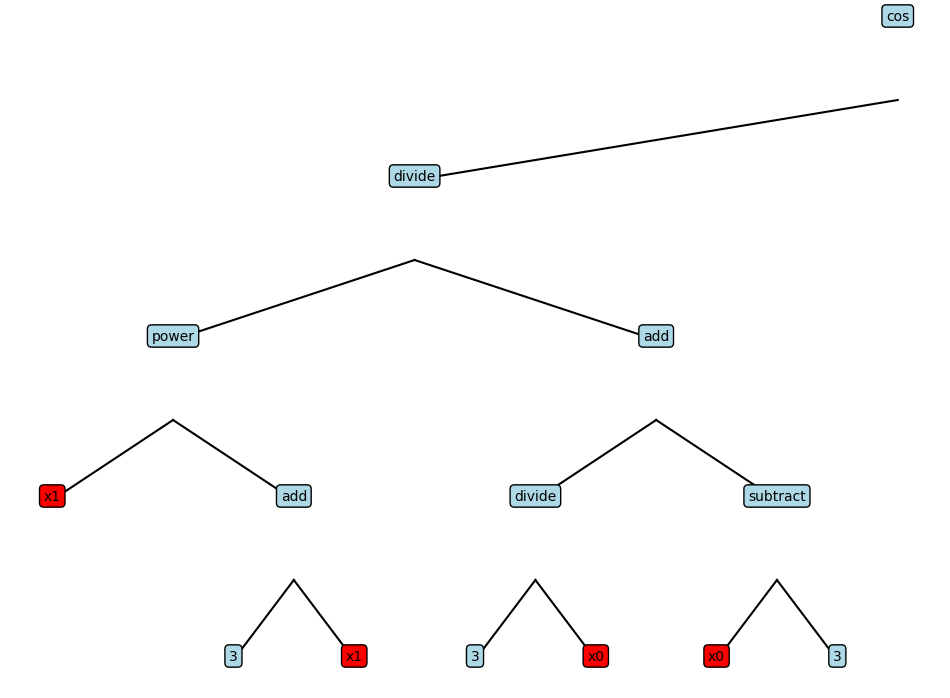

In [29]:
#UNCOMMENT TO PROFILE THE CODE (and comment the rest of the code)
# cProfile.run("regressor.evolve()",sort="tottime") #for profiling so we can see the time taken by each function
#the output will include the following columns:
#tottime: Total time spent in the function (excluding time spent in other functions it calls).
#cumtime: Cumulative time spent in the function (including time spent in sub-functions).
def revert_formula(formula, x_stats, y_stats):
    """
    Revert a formula from normalized space to original space for min-max normalization.

    Parameters:
        formula: str, symbolic regression formula in normalized space.
        x_stats: dict, stats for input normalization (min, max).
        y_stats: dict, stats for output normalization (min, max).

    Returns:
        str, formula in the original space.
    """
    x_mins = x_stats["min"].flatten()
    x_maxs = x_stats["max"].flatten()
    y_min = y_stats["min"]
    y_max = y_stats["max"]

    # Wrap variables with normalization transformations
    for i, (x_min, x_max) in enumerate(zip(x_mins, x_maxs)):
        formula = formula.replace(
            f"x[{i}]",
            f"(x[{i}] * ({x_max} - {x_min}) + {x_min})"
        )

    # Apply the output transformation
    reverted_formula = f"(({formula}) * ({y_max} - {y_min})) + {y_min}"
    return reverted_formula



def compute_fitness_from_formula(formula, x_data, y_data):
    """
    Compute MSE fitness directly from a reverted formula.

    Parameters:
        formula: str, reverted symbolic regression formula.
        x_data: np.ndarray, input data in original scale (variables, samples).
        y_data: np.ndarray, true output data in original scale (samples).

    Returns:
        float, MSE fitness.
    """
    # Convert the formula to a lambda function
    eval_formula = eval(f"lambda x: {formula}", {"np": np})

    # Compute predictions
    y_pred = eval_formula(x_data)

    

    # Calculate MSE
    mse = np.mean(np.square(y_data - y_pred))
    return mse 


# Execute the algorithm
best_tree, best_fitness = regressor.evolve()

# Calculate the fitness on original data
best_tree.compute_fitness(test="test")


# Revert the formula
final_formula = best_tree.to_np_formula()
reverted_formula = revert_formula(final_formula, x_stats, y_stats)
print(f"Reverted Formula:\n{reverted_formula}")


print(f"Test Fitness: {best_tree.fitness}")
print(f"Train-Test Discrepancy: {best_fitness-best_tree.fitness}")
best_tree.compute_fitness(test="all")
print(f"All Fitness: {best_tree.fitness}")
test_fitness_original=compute_fitness_from_formula(reverted_formula, x_test, y_test)
print(f"Test Fitness Original: {test_fitness_original}")
all_fitness_original=compute_fitness_from_formula(reverted_formula, x_train, y_train)
print(f"all Fitness Original: {all_fitness_original}")


#Print the best tree
print(f"Best Fitness History: {regressor.best_fitness_history}, changed {len(regressor.best_fitness_history)} times")
print("Best Tree:")
best_tree.add_drawing()


Collapsed formula: np.add(np.multiply(np.add(x[1], np.divide(x[0], -1.0341201430008375)), 0.041881185336551316), x[0])
Best Tree after collapsing:


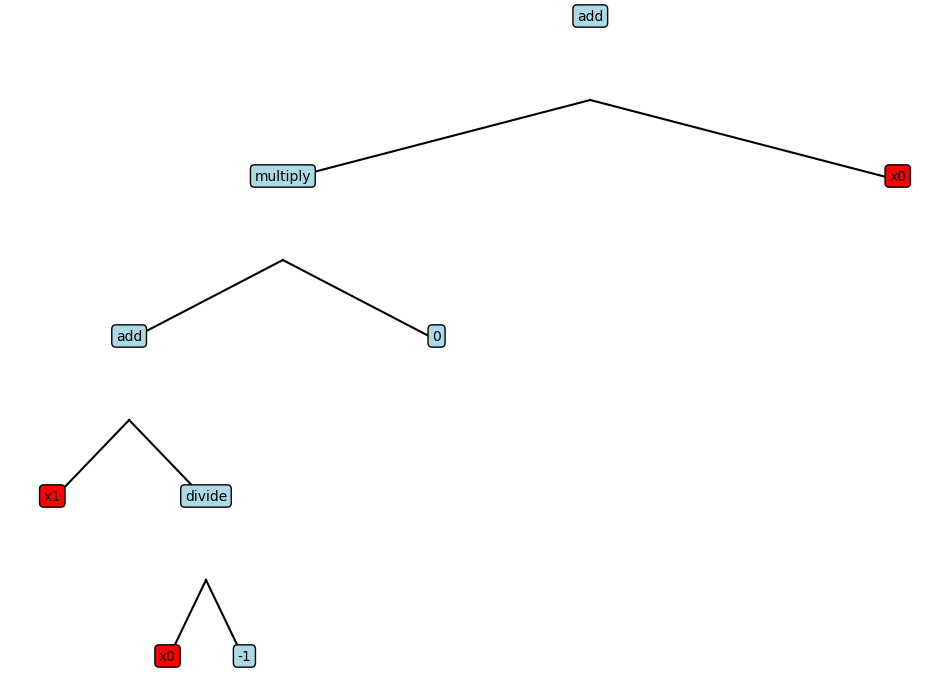

In [20]:
#Collapse branches that can be simplified
Tree.collapse_branch(best_tree.root,0,force_collapse=True)
print(f"Collapsed formula: {best_tree.to_np_formula()}")
print("Best Tree after collapsing:")
best_tree.add_drawing()


In [21]:

# def test_formula(x):
#     pass



# x_tot=np.concatenate((x_train,x_test),axis=1)
# y_tot=np.concatenate((y_train,y_test))
# squared_errors = 0
# for i in range(1):
#     y_pred = test_formula(x_tot[:, i])
                 
#     squared_errors += np.square(y_tot[i] - y_pred) 

# print( squared_errors / x_tot.shape[1])
   

# def testing(tree):
#    tree.compute_fitness()
#    tree.compute_fitness2()

# cProfile.run("testing(best_tree)",sort="tottime") #for profiling so we can see the time taken by each function


# best_tree.compute_fitness()
# print(best_tree.fitness)
# best_tree.compute_fitness2()
# print(best_tree.fitness)
